Adversarial attacks tutorial
==

Deep Learning (and in particula Convolutional Neural Networks) has continued to achieve great success in solving increasingly complex problems related to Computer Vision. Deep Nets are currently the best and only way to teach a computer programme to "see" objects, recognize what is presented in images, spot anomalies, detect motion, recognize fake pictures, etc.

However, deep models are susceptible to **adversarial attacks**. In 2015, Ian Goodfellow showed that modifying an image by a small amount of noise that is undetectable to human eye can drastically change how this image is classified by the same *State-of-the-Art* (SOTA) model.

In this tutorial, we will see an example of such **adversarial attack**.

The model we will discuss is called **Fast Gradient Sign Method** (FGSM), but there are many other attack techniques, not only on image-like data.

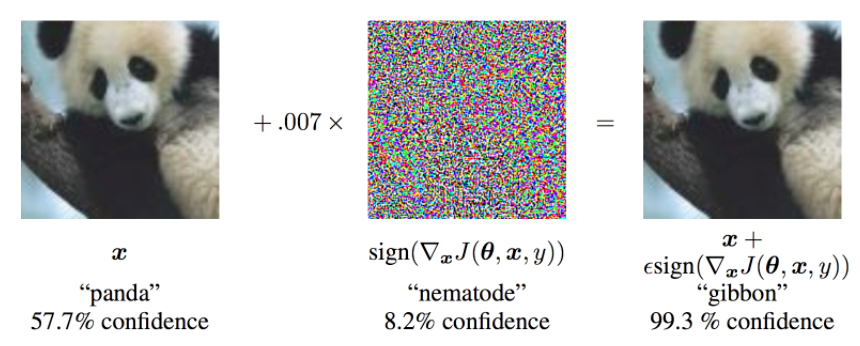

### Importing libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

### Load the dataset

We will work with MNIST dataset (hand-written digits), but the larger version of it when we used sklearn library. In particular, our images are going to be higher resolution (28x28 pixels).

MNIST dataset is easily downloadable using Torch. The below code snippet will
* Download the dataset if you have not got it in your current directory. If you have already downloaded it, the dataset will not re-download again.
* Create a *data loader* to load data in batches to the model at training / testing (the same way we did this previously when training simple CNN networks)
* Shuffle the data as necessary

In [2]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data-mnist', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)


C:\Users\Yun Haishn\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Load the model

Let's use a pre-trained model. You could pick one you like the most, or use Resnet like we do in the transfer learning tutorial.

In this tutorial, we will use a simpler model, called LeNet-5 (it has 5 layers), to make the demonstration faster and in line with the original FGSM paper from 2015.

This model we downloaded from another repository and saved down with this tutorial to make it more straightforward.

The file that we need is called ````lenet_mnist_model.pth````. This pth file contains values of paremters (weights) of the pre-trained network.

We call this the *"state"* of the model. However, this is not the model itself. In order to load a usable model out pf a ````pth```` file, we need to 
* re-create the model as a class (this is an empty framework with all parameters random or 0)
* create an instance of this model
* add the pre-trained values of all parameters from the ````pth```` file onto this empty framework

Only then are we able to use the model.

In [3]:
# path to the model parameters
pretrained_model = "./lenet_mnist_model.pth"


As an exercise, build the model class and initialize it yourself.

LeNet's stricture is as follows:
* convolutional layer with 1 input channel, 10 output channels and 5x5 kernel
* convolutional layer 20 output channels and 5x5 kernel
* dropout layer (````nn.Dropout2d()````)
* a fully connected layers with 50 hidden neurons

The output should be of dimension 10x2 (10 classes for the MNIST dataset task)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,10,5)
        self.relu=nn.ReLU()
        self.conv2=nn.Conv2d(10,20,5)
        self.drop=nn.Dropout2d()
        self.fc1=nn.Linear(320,50)
        self.fc2=nn.Linear(50,10)
    def forward(self,x):
        x=self.conv1(x)
        x=F.max_pool2d(x,kernel_size=2)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.drop(x)
        x=F.max_pool2d(x,kernel_size=2)
        x=self.relu(x)
        x=x.view(-1,320)
        x=self.fc1(x)
        x=self.relu(x)
        x=F.dropout(x,training=self.training)
        x=self.fc2(x)
        x=F.log_softmax(x,dim=1)
        return x
model = Net()





Now, load the weights from ````lenet_mnist_model.pth```` onto the model. We do this using ````torch.load_state_dict()```` function.

In [9]:
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))


<All keys matched successfully>

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0, momentum=0)
model.eval()



Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Don't forget to set your model in ````eval```` mode to prevent any extra training from happening.


### FGSM Attack

Let's define the FGSM attack function.

The FGSM attack modifies the input data image $x$ via
$$ x' = x + \epsilon \times sign(\nabla_\text{x} L) $$

Where
* $\epsilon$ is a small number representing the **size** of the attack
* $sign(z)$ is a function that outputs 1 if $z>0$ or -1 when $z\leq 0$
* $L$ is the loss function
* $\nabla_x L$ tells us how the loss function changes with respect to the input data $x$. That is, *if we perturb (modify) the input data, what impact does this have on the loss function's value, all other things being equal?*

In other words, we are modifying each pixel of the input image by a small amount in the direction in which it will affect the loss function the most, that is, the gradient direction.

To make this happen, 

In [11]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    return perturbed_image





In [12]:
def test(model, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True      
        # Forward pass the data through the model
        output=model.forward(data)
        init_pred = output.max(1, keepdim=True)[1]
         # get the index of the max log-probability

        # Calculate the loss
        criterion = nn.CrossEntropyLoss()
        loss=criterion(output,target)

        # Zero all existing gradients
        optimizer.zero_grad
        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad=data.grad

        # Call FGSM Attack (your function you defined above)
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model.forward(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples



In [14]:
accuracies = []
examples = []
epsilons=[0,0.5,1,1.5,2,2.5,3]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    
    


Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.5	Test Accuracy = 73 / 10000 = 0.0073
Epsilon: 1	Test Accuracy = 67 / 10000 = 0.0067
Epsilon: 1.5	Test Accuracy = 83 / 10000 = 0.0083
Epsilon: 2	Test Accuracy = 97 / 10000 = 0.0097
Epsilon: 2.5	Test Accuracy = 106 / 10000 = 0.0106
Epsilon: 3	Test Accuracy = 116 / 10000 = 0.0116


## Results

Let's investigate how increaseing $\epsilon$ (making the attack stronger and stronger) will impact the accuracy of the model.

To do this, repeat the experiment for different values of $\epsilon$ and save down your answers. Then, you can use a plot, or another way, to compare accuracies of your model for different sizes of the adversarial attack.

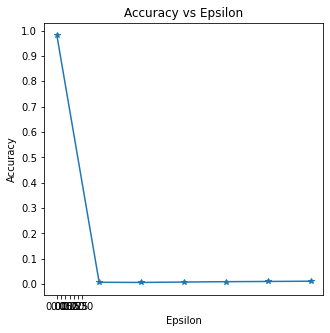

In [15]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Adversarial examples
For completeness, we include the following code to show what the perturbed (attacked) images look like, as well as what the model's classification decision is for each, for different values of $\epsilon$. You are encouraged to play with this code and see if you can find curious or surprising results.

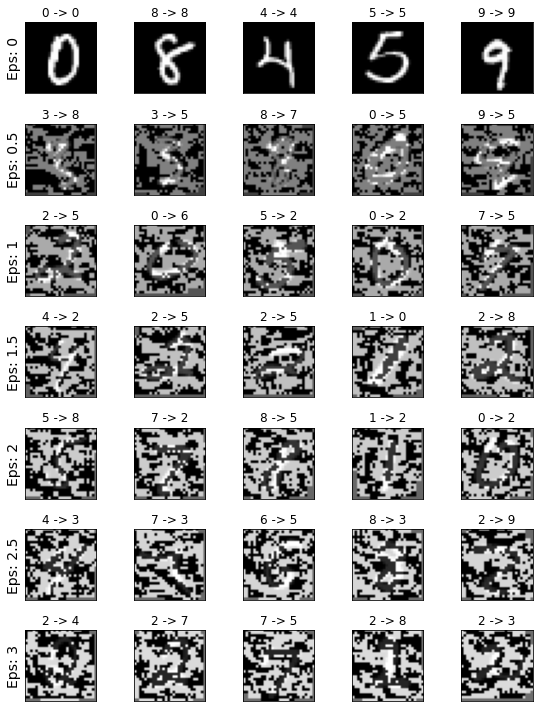

In [16]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()